In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

- PREVIOUS_APPLICATION 데이터에서 피처 추출하여 모델링(Version_3)
- 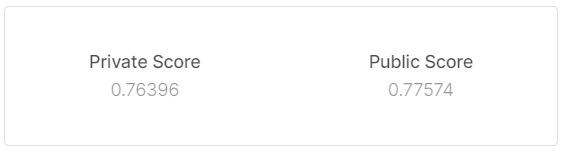

### Version_4 : bureau.scv, bureau_balance 데이터 사용
- Credit Bureau(CB)에 기록된 타 금융 기관에서 제공받은 모든 고객의 이전 신용 거래
- 대출 신청일 전에 CB에 기록된 고객이 가지고 있던 신용 거래 수만큼의 행

    - *Credit Bureau는 개인신용평가기관으로 신용등급을 조회할 때 사용
    - *국내에는 나이스평가정보(NICE)와 코리아크레딧뷰로(KCB)가 대표적임

In [ ]:
# 라이브러리 및 데이터 세트 로딩
import numpy as np
import pandas as pd
import gc
import time

%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

#### bureau 데이터에서 새로운 FEATURE 만들어서 APPLICATION_TRAIN, APPLICATION_TEST 과 PREVIOUS-APPLICATION 결합하여 모델링
- APPLICATION_TRAIN, APPLICATION_TEST, PREVIOUS_APPLICATION, BUREAU, BUREAU_BALANCE 데이터 READ
- APPLICATION_TRAIN 과 APPLICATION_TEST 데이터 CONCAT 함수 사용하여 APPS 이름으로 통합
- PREVIOUS_APPLICATION 데이터에서 (지난수업에했던 부분) FEATURE APPS에 추가

In [ ]:
# application-train 과  application_test 데이터 read
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
#app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

In [ ]:
# app_train 과 app_test를 함께 가공을 해야하기 때문에 concat 이용하여 통합

#apps = pd.concat([app_train, app_test])
print("Size of application_train data", app_train.shape)
#print("Size of application_test data", app_test.shape)
#print("Size of apps", apps.shape)

In [ ]:
# previous_application, bureau, bureau_balance 데이터 read

#prev = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_bal = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')
    

In [ ]:
#print("Size of previous_application data", prev.shape)
print("Size of bureau data", bureau.shape)
print("Size of bureau-balance data", bureau_bal.shape)

In [ ]:
# 인덱스를 통해서 확인도 가능함
print("The number of features is :",bureau.shape[1],"The number of row is:",bureau.shape[0])

In [ ]:
# bureau 데이터를 확인

bureau.head(15)

# day_credit에서 -497 과 -208 값은 같은 ID 215354에 해당

In [ ]:
# 215354 ID 고객의 이전 신용 거래 확인
bureau[bureau['SK_ID_CURR'] == 215354]

## EDA - Target 유형에 따라 bureau 데이터 비교
- application_train 데이터와 bureau 데이터 merge
- NULL 값 확인(데이터에서 NULL 값 비율) 
- Categorical date --> CREDIT ACTIVE, CREDIT_CURRENCY, CREDIT TYPE 기반 분석

In [ ]:
# TARGET 값을 가져오기 위해 bureau를 apps와 조인
app_bureau = bureau.merge(app_train[['SK_ID_CURR', 'TARGET']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
app_bureau.shape

In [ ]:
#import platform
#import matplotlib.font_manager as fm

#plt.rcParams['font.family']= "Malgun Gothic"
#plt.rcParams['axes.unicode_minus'] = False

#from IPython.display import set_matplotlib_formats

#set_matplotlib_formats("retina")###

In [ ]:
f,ax=plt.subplots(1,2,figsize=(12,6))
app_train.TARGET.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Distribution of Target')
ax[0].set_ylabel('')
sns.countplot('TARGET',data=app_train,ax=ax[1])
ax[1].set_title('Target count')
plt.show()

### NULL값 확인


In [ ]:
# Null 값 확인 가능한 사용자 함수 (데이터에서 비율)

def nulldata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(15,10))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of null values', fontsize=15)
    plt.title('Percent null data by feature', fontsize=15)
    return ms

In [ ]:
# bureau 데이터만 확인
nulldata(bureau)

In [ ]:
# 위 nulldata 함수를 사용하면 좋음 거이 모든 데이터에 적용 가능

nulldata(app_train)

### Numerical Features(숫자형 피처) 과 Categorical Features(범주/object 피처) 구분

In [ ]:
# Numerical Features(숫자형 피처) 과 Categorical Features(범주/object 피처) 구분 함수
# 다른 데이터에 사용 가능하니, 기말프로젝트에 사용해도 좋은

def type_features(data):
    categorical_features = data.select_dtypes(include = ["object"]).columns
    numerical_features = data.select_dtypes(exclude = ["object"]).columns
    print( "categorical_features :",categorical_features)
    print('-----'*40)
    print("numerical_features:",numerical_features)

In [ ]:
# bureau 데이터에만 적용 해 보기
type_features(bureau)

### Numerical Features & Categorical Feature 위한 시각화 함수
- CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'

In [ ]:
# 시각화 함수
def plot_re(df,t1='',t2=''):
    f,ax=plt.subplots(1,2,figsize=(12,8))
    df[[t1,t2]].groupby([t1]).count().plot.bar(ax=ax[0],color='Blue')
    ax[0].set_title('count of customer on '+t1)
    sns.countplot(t1,hue=t2,data=df,ax=ax[1],palette="spring")
    ax[1].set_title(t1+': Target 0 vs Target 1')
    # Rotate x-labels
    plt.xticks(rotation=-90)
    a=plt.show()
    return a

### CREDIT ACTIVE, CREDIT_CURRENCY, CREDIT TYPE 기반 EDA

In [ ]:
# 함수 호출 
# 대출 상태에 따른 Target
plot_re(app_bureau,'CREDIT_ACTIVE','TARGET')

# Closed 된 고객 그룹에 속한 고객보다는 신용 활성(active) 고객은 비 지급 자 수가 많음

In [ ]:
# CREDIT_CURRENCY: 대출 금액 화폐유형에 따른 Target
plot_re(app_bureau,'CREDIT_CURRENCY','TARGET')

# currency 1을 사용하는 CREDIT_CURRENCY 고객은 비 지급 자 수가 많음

In [ ]:
# Credit type 따른 Target
plot_re(app_bureau,'CREDIT_TYPE','TARGET')

# 주어진 플롯을 바탕으로 CREDIT_TYPE 소비자 신용(consumer credit)이 대출을받지 않는 사람의 수가 많다는 것이 분명함

### Numerical Feature 시각화
- 함수 사용
- seaborn 사용

In [ ]:
f, ax = plt.subplots(2,3,figsize=(13, 10))


# DAYS_CREDIT: 현재 대출 신청 일 기준 과거 대출 신청 지난 기간 분포 확인
sns.distplot(app_bureau.DAYS_CREDIT.dropna(), kde=True, color="g", 
             ax=ax[0,0]).set_title('DAYS CREDIT Distribution')

# CREDIT_DAY_OVERDUE: 대출 신청 시 CB 크레딧 연체 일수
sns.distplot(app_bureau.CREDIT_DAY_OVERDUE.dropna(), kde=True, color="b",
             ax=ax[0,1]).set_title(' CREDIT DAY OVERDUE Distribution')


# DAYS_CREDIT_UPDATE: 대출 신청전 마지막 정보 받은 기간
sns.distplot(bureau.DAYS_CREDIT_UPDATE.dropna(), kde=True, 
             color="r", ax=ax[0,2]).set_title('DAYS CREDIT UPDATE Distribution')


# AMT_CREDIT_SUM_LIMIT: 신용 카드 현재 신용한도
sns.distplot(bureau.AMT_CREDIT_SUM_LIMIT.dropna(), kde=True, color="g", 
             ax=ax[1,0]).set_title(' Distribution')


# AMT_CREDIT_SUM_DEBT: 현재 채무 금액 총액
sns.distplot(bureau.AMT_CREDIT_SUM_DEBT.dropna(), kde=True, color="b",
             ax=ax[1,1]).set_title(' Distribution')

 
# AMT_CREDIT_SUM_OVERDUE: 최대 연체금액
sns.distplot(bureau.AMT_CREDIT_SUM_OVERDUE.dropna(), kde=True, 
             color="r", ax=ax[1,2]).set_title('DAYS CREDIT UPDATE Distribution')

In [ ]:
# 신용 한도를 초과하여 연체 된 고객이 있을까요?

sns.jointplot(x="AMT_CREDIT_SUM_LIMIT", y="AMT_CREDIT_SUM_OVERDUE", data=app_bureau)
plt.show()

# 연체 된 신용 한도를 초과하는 고객이 없음을 알 수 있

In [ ]:
# CNT_CREDIT_PROLONG 신용 연장 횟수에 따른 Target
plot_re(app_bureau,'CNT_CREDIT_PROLONG','TARGET')

In [ ]:
# 신용(크레딧)이 몇 번 연장을 했는지, 연장되었다면 어떤 대출 type 인지 알아보는 시각화

# CNT_CREDIT_PROLONG 신용 연장 횟수
# CREDIT_TYPE 대출 유형

sns.stripplot(x="CNT_CREDIT_PROLONG", y="CREDIT_TYPE", data=app_bureau)
plt.show()

# 결과: 신용 카드 유형 신용이 연장 된 최대 횟수를 확인할 수 있음

In [ ]:
# correlated features

corrmat = app_bureau.corr()
top_corr_features = corrmat.index[abs(corrmat["TARGET"])>=0.03]
plt.figure(figsize=(12,8))
g = sns.heatmap(app_bureau[top_corr_features].corr(),annot=True,cmap="Oranges")

### bureau_balance 에 대한 EDA

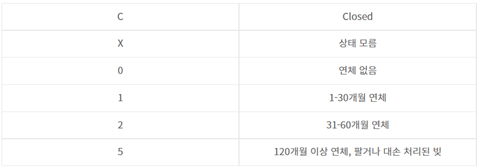

In [ ]:
bureau_bal.head(15)

In [ ]:
print("the number of columns",bureau_bal.shape[1],"the number of rows :",bureau_bal.shape[0])

In [ ]:
type_features(bureau_bal)

In [ ]:
# null 값을 확인

total = bureau_bal.isnull().sum().sort_values(ascending = False)
percent = (bureau_bal.isnull().sum()/bureau_bal.isnull().count()*100).sort_values(ascending = False)
ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
ms= ms[ms["Percent"] > 0]
ms

In [ ]:
f, ax = plt.subplots(figsize=(7,5))

# Types of colors
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']

# Count Plot 
sns.countplot(x='STATUS', data=bureau_bal,palette=color_types).set_title('count based on status type')

In [ ]:
# 숫차로 확인
bureau_bal['STATUS'].value_counts()

In [ ]:
# bureau_bal 데이터와 bureau 데이터 사이즈 확인
print(bureau_bal.shape, bureau.shape)

In [ ]:
# bureau_bal 데이터와 bureau 데이터와 join
bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
bureau_bal.shape


In [ ]:
bureau_bal.head()

## Bureau Feature Engineering 
- 고객 당 대출은 몇 건입니까? --> 많을수록 좋다 ... 적을수록 좋다??
- 고객 당 과거 대출 유형 수는? 
- 고객 당 유형별 평균 과거 대출 수는?
- 대출 상태의 현재 활성(active) 대출 비율은?
- 고객이 과거에 대출을 얼마나 자주 받았습니까?
    - 정기적으로 대출을 받았습니까? 그렇다면 계획된 대출 일 수 있음
    - 첫 번째 대출 날짜와 다음 대출 날짜 사이의 간격이 짧습니까? 그렇다면 재정적으로 어려움을 겪고 있다고 판단해도 될까요...
- 대출 종료일이 지난 고객 당 대출 비율은 얼마나 될까?
- ...

In [ ]:
# 고객 당 과거 대출 수

bureau_fe1= bureau
PAST_LOANS_PER_CUS= bureau_fe1[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})
bureau_fe1 = bureau_fe1.merge(PAST_LOANS_PER_CUS, on = ['SK_ID_CURR'], how = 'left')
print(bureau.shape)
print(bureau_fe1.shape)
bureau_fe1.head(10)

In [ ]:
# 고객 당 과거 대출 유형 수

BUREAU_LOAN_TYPES = bureau_fe1[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
bureau_fe1 = bureau_fe1.merge(BUREAU_LOAN_TYPES, on = ['SK_ID_CURR'], how = 'left')
print(bureau_fe1.shape)
bureau_fe1.head()

In [ ]:
# 고객 당 유형별 평균 과거 대출 수 = 고객 당 과거 대출 수 / 고객 당 과거 대출 유형 수
# --> 고객이 다양한 유형의 대출을 받거나 단일 유형의 대출에 집중하고 있는지 확인가능

bureau_fe1['AVERAGE_LOAN_TYPE'] = bureau_fe1['BUREAU_LOAN_COUNT']/bureau_fe1['BUREAU_LOAN_TYPES']

print(bureau_fe1.shape)
bureau_fe1.head(15)

In [ ]:
# 필요없는 컬럼은 삭제

del bureau_fe1['BUREAU_LOAN_COUNT'], bureau_fe1['BUREAU_LOAN_TYPES']
print(bureau_fe1.shape)
bureau_fe1.head()

In [ ]:
# BUREAU 데이터의 active 대출 비율 (CREDIT이 ACTIVE 또는 CLOSED인지)


bureau_fe1['CREDIT_ACTIVE_CLOSED'] = bureau_fe1['CREDIT_ACTIVE']

# Closed 인 경우에는 y에는 0, ACTIVE 인경우에는 Y=1 
def f(x):
    if x == 'Closed':
        y = 0
    else:
        y = 1    
    return y

bureau_fe1['CREDIT_ACTIVE_CLOSED'] = bureau_fe1.apply(lambda x: f(x.CREDIT_ACTIVE), axis = 1)

# CUSTOMER 당 활성 상태인 평균 대출 수 계산
grp = bureau_fe1.groupby(by = ['SK_ID_CURR'])['CREDIT_ACTIVE_CLOSED'].mean().reset_index().rename(index=str, columns={'CREDIT_ACTIVE_CLOSED':'ACTIVE_LOANS_PERCENTAGE'})
bureau_fe1= bureau_fe1.merge(grp, on = ['SK_ID_CURR'], how = 'left')
# 중복된 컬럼 삭제
del bureau_fe1['CREDIT_ACTIVE_CLOSED']
print(bureau_fe1.shape)

In [ ]:
bureau_fe1[bureau_fe1['SK_ID_CURR'] == 215354]

In [ ]:
# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 피처 가공

# 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
bureau_fe1['BUREAU_ENDDATE_FACT_DIFF'] = bureau_fe1['DAYS_CREDIT_ENDDATE'] - bureau_fe1['DAYS_ENDDATE_FACT']
bureau_fe1['BUREAU_CREDIT_FACT_DIFF'] = bureau_fe1['DAYS_CREDIT'] - bureau_fe1['DAYS_ENDDATE_FACT']
bureau_fe1['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau_fe1['DAYS_CREDIT'] - bureau_fe1['DAYS_CREDIT_ENDDATE']

# 채무 금액 대비/대출 금액 비율 및 차이 가공
bureau_fe1['BUREAU_CREDIT_DEBT_RATIO'] = bureau_fe1['AMT_CREDIT_SUM_DEBT'] / bureau_fe1['AMT_CREDIT_SUM']
bureau_fe1['BUREAU_CREDIT_DEBT_DIFF'] = bureau_fe1['AMT_CREDIT_SUM_DEBT'] - bureau_fe1['AMT_CREDIT_SUM']

bureau_fe1.head()

In [ ]:
# 신용 연장 평균 횟수 
bureau_fe1['CNT_CREDIT_PROLONG'] = bureau_fe1['CNT_CREDIT_PROLONG'].fillna(0)
grp = bureau_fe1[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby(by = ['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index().rename(index = str, columns = { 'CNT_CREDIT_PROLONG':'AVG_CREDITDAYS_PROLONGED'})
bureau_fe1 = bureau_fe1.merge(grp, on = ['SK_ID_CURR'], how = 'left')
print(bureau_fe1.shape)
bureau_fe1.head()

### bureau_fe1, bureau_bal 조인

In [ ]:
#bureau_fe1 = bureau_fe1.merge(bureau_bal, on='SK_ID_CURR', how='left')
#print(bureau_fe1.shape)

##### 새롭게 기존 Application, previous 가공 데이터 세트와 bureau, bureau_balance 가공 데이터 세트 결합 

##### Application, previous, bureau, bureau_balance 데이터 가공, 인코딩, 학습/테스트 분리, 학습 수행